In [74]:
import csv 
import pandas as pd
import numpy as np

dataframe = pd.read_csv('Labs/data/auto-mpg.csv', na_values=['NA','?'])

In [75]:
import collections
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) * (normalized_high - normalized_low) + normalized_low

In [76]:
cars = dataframe['name']

dataframe.drop('name',1,inplace=True)

missing_median(dataframe, 'horsepower')

encode_text_dummy(dataframe, 'origin')

x,y = to_xy(dataframe,"mpg")

<ipython-input-76-1affd3ae97f5>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  dataframe.drop('name',1,inplace=True)


In [77]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [78]:
# Create linear regression object
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [79]:
pred = model.predict(x_test)

In [80]:
for i in range(10):
    print("True MPG : ",y_test[i],"Prediction : ", pred[i])

True MPG :  33.0 Prediction :  32.591156
True MPG :  28.0 Prediction :  29.21645
True MPG :  19.0 Prediction :  20.805851
True MPG :  13.0 Prediction :  16.829762
True MPG :  14.0 Prediction :  12.529545
True MPG :  27.0 Prediction :  26.99945
True MPG :  24.0 Prediction :  27.49215
True MPG :  13.0 Prediction :  9.832294
True MPG :  17.0 Prediction :  17.067535
True MPG :  21.0 Prediction :  21.740635


In [81]:
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

Final score (RMSE): 3.0320844650268555


In [82]:
for i in range(20):
    print("{}. Car name: {}, MPG: {}, predicted MPG: {}".format(i+1,cars[i],y_test[i],pred[i]))

1. Car name: chevrolet chevelle malibu, MPG: 33.0, predicted MPG: 32.591156005859375
2. Car name: buick skylark 320, MPG: 28.0, predicted MPG: 29.216449737548828
3. Car name: plymouth satellite, MPG: 19.0, predicted MPG: 20.805850982666016
4. Car name: amc rebel sst, MPG: 13.0, predicted MPG: 16.829761505126953
5. Car name: ford torino, MPG: 14.0, predicted MPG: 12.529544830322266
6. Car name: ford galaxie 500, MPG: 27.0, predicted MPG: 26.99945068359375
7. Car name: chevrolet impala, MPG: 24.0, predicted MPG: 27.492149353027344
8. Car name: plymouth fury iii, MPG: 13.0, predicted MPG: 9.832294464111328
9. Car name: pontiac catalina, MPG: 17.0, predicted MPG: 17.067535400390625
10. Car name: amc ambassador dpl, MPG: 21.0, predicted MPG: 21.74063491821289
11. Car name: dodge challenger se, MPG: 15.0, predicted MPG: 12.620494842529297
12. Car name: plymouth 'cuda 340, MPG: 38.0, predicted MPG: 35.94993591308594
13. Car name: chevrolet monte carlo, MPG: 26.0, predicted MPG: 24.71072387695

Root mean squared error = 3.0321
R-squared = 0.8398


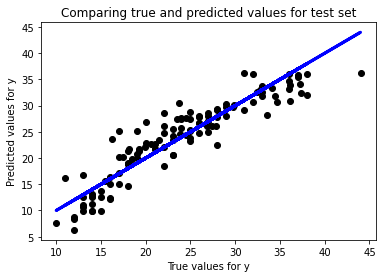

In [83]:
# Comparing true versus predicted values
plt.scatter(y_test, pred, color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, pred)))
print('R-squared = %.4f' % r2_score(y_test, pred))

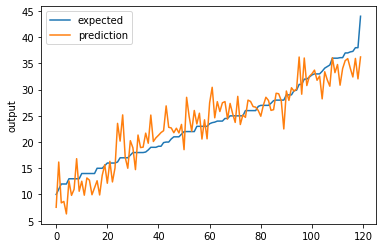

In [24]:
chart_regression(pred, y_test)

Text(0.5, 1.0, 'Correlation between X4 and X5 = 0.9509')

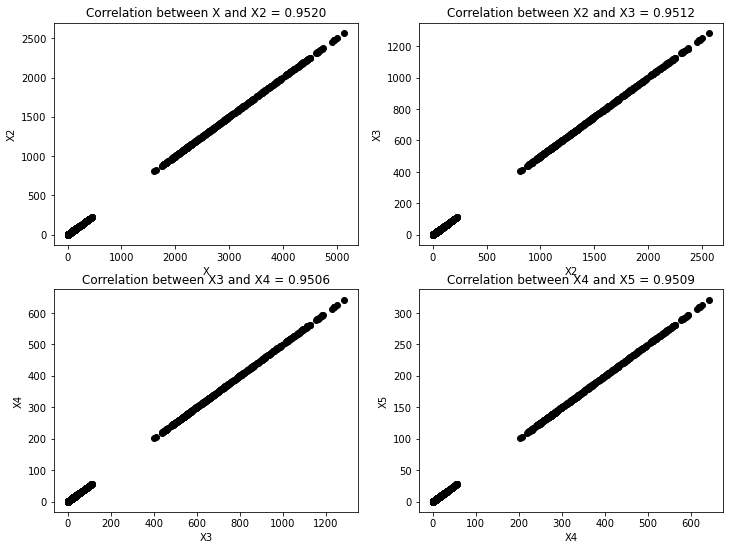

In [84]:
seed = 1
np.random.seed(seed)
x2 = 0.5*x + np.random.normal(0, 0.04, size=y.shape[0]).reshape(-1,1)
x3 = 0.5*x2 + np.random.normal(0, 0.01, size=y.shape[0]).reshape(-1,1)
x4 = 0.5*x3 + np.random.normal(0, 0.01, size=y.shape[0]).reshape(-1,1)
x5 = 0.5*x4 + np.random.normal(0, 0.01, size=y.shape[0]).reshape(-1,1)

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(12,9))
ax1.scatter(x, x2, color='black')
ax1.set_xlabel('X')
ax1.set_ylabel('X2')
c = np.corrcoef(np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X and X2 = %.4f' % (c[0,1])
ax1.set_title(titlestr)

ax2.scatter(x2, x3, color='black')
ax2.set_xlabel('X2')
ax2.set_ylabel('X3')
c = np.corrcoef(np.column_stack((x2[:-y_test.shape[0]],x3[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X2 and X3 = %.4f' % (c[0,1])
ax2.set_title(titlestr)

ax3.scatter(x3, x4, color='black')
ax3.set_xlabel('X3')
ax3.set_ylabel('X4')
c = np.corrcoef(np.column_stack((x3[:-y_test.shape[0]],x4[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X3 and X4 = %.4f' % (c[0,1])
ax3.set_title(titlestr)

ax4.scatter(x4, x5, color='black')
ax4.set_xlabel('X4')
ax4.set_ylabel('X5')
c = np.corrcoef(np.column_stack((x4[:-y_test.shape[0]],x5[:-y_test.shape[0]])).T)
titlestr = 'Correlation between X4 and X5 = %.4f' % (c[0,1])
ax4.set_title(titlestr)

In [85]:
X_train2 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]]))
X_test2 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:]))
X_train3 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]],x3[:-y_test.shape[0]]))
X_test3 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:],x3[-y_test.shape[0]:]))
X_train4 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]],x3[:-y_test.shape[0]],x4[:-y_test.shape[0]]))
X_test4 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:],x3[-y_test.shape[0]:],x4[-y_test.shape[0]:]))
X_train5 = np.column_stack((x[:-y_test.shape[0]],x2[:-y_test.shape[0]],x3[:-y_test.shape[0]],x4[:-y_test.shape[0]],x5[:-y_test.shape[0]]))
X_test5 = np.column_stack((x[-y_test.shape[0]:],x2[-y_test.shape[0]:],x3[-y_test.shape[0]:],x4[-y_test.shape[0]:],x5[-y_test.shape[0]:]))

In [86]:
regr2 = linear_model.LinearRegression()
regr2.fit(X_train2, y_train)

regr3 = linear_model.LinearRegression()
regr3.fit(X_train3, y_train)

regr4 = linear_model.LinearRegression()
regr4.fit(X_train4, y_train)

regr5 = linear_model.LinearRegression()
regr5.fit(X_train5, y_train)

LinearRegression()

In [87]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)
y_pred_train2 = regr2.predict(X_train2)
y_pred_test2 = regr2.predict(X_test2)
y_pred_train3 = regr3.predict(X_train3)
y_pred_test3 = regr3.predict(X_test3)
y_pred_train4 = regr4.predict(X_train4)
y_pred_test4 = regr4.predict(X_test4)
y_pred_train5 = regr5.predict(X_train5)
y_pred_test5 = regr5.predict(X_test5)

In [89]:
columns = ['Model', 'Train error', 'Test error', 'Sum of Absolute Weights']
model1 = "%.2f X + %.2f" % (model.coef_[0][0], model.intercept_[0])
values1 = [ model1, np.sqrt(mean_squared_error(y_train, y_pred_train)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test)),
           np.absolute(model.coef_[0]).sum() + np.absolute(model.intercept_)]

model2 = "%.2f X + %.2f X2 + %.2f" % (regr2.coef_[0][0], regr2.coef_[0][1], regr2.intercept_[0])
values2 = [ model2, np.sqrt(mean_squared_error(y_train, y_pred_train2)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test2)),
           np.absolute(regr2.coef_[0]).sum() + np.absolute(regr2.intercept_[0])]

model3 = "%.2f X + %.2f X2 + %.2f X3 + %.2f" % (regr3.coef_[0][0], regr3.coef_[0][1], 
                                                regr3.coef_[0][2], regr3.intercept_[0])
values3 = [ model3, np.sqrt(mean_squared_error(y_train, y_pred_train3)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test3)),
           np.absolute(regr3.coef_[0]).sum() + np.absolute(regr3.intercept_[0])]

model4 = "%.2f X + %.2f X2 + %.2f X3 + %.2f X4 + %.2f" % (regr4.coef_[0][0], regr4.coef_[0][1], 
                                        regr4.coef_[0][2], regr4.coef_[0][3], regr4.intercept_[0])
values4 = [ model4, np.sqrt(mean_squared_error(y_train, y_pred_train4)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test4)),
           np.absolute(regr4.coef_[0]).sum() + np.absolute(regr4.intercept_[0])]

model5 = "%.2f X + %.2f X2 + %.2f X3 + %.2f X4 + %.2f X5 + %.2f" % (regr5.coef_[0][0], 
                                        regr5.coef_[0][1], regr5.coef_[0][2], 
                                        regr5.coef_[0][3], regr5.coef_[0][4], regr5.intercept_[0])
values5 = [ model5, np.sqrt(mean_squared_error(y_train, y_pred_train5)), 
           np.sqrt(mean_squared_error(y_test, y_pred_test5)),
           np.absolute(regr5.coef_[0]).sum() + np.absolute(regr5.intercept_[0])]

results = pd.DataFrame([values1, values2, values3, values4, values5], columns=columns)

plt.plot(results['Sum of Absolute Weights'], results['Train error'], 'ro-')
plt.plot(results['Sum of Absolute Weights'], results['Test error'], 'k*--')
plt.legend(['Train error', 'Test error'])
plt.xlabel('Sum of Absolute Weights')
plt.ylabel('Error rate')

results

IndexError: invalid index to scalar variable.

Slope =  0.011774411
Intercept =  -21.08006


Text(0, 0.5, 'y')

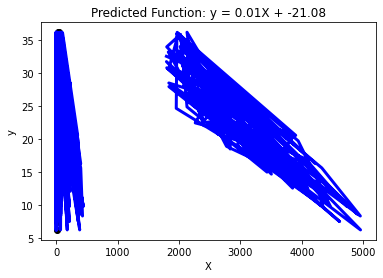

In [40]:
# Display model parameters
print('Slope = ', model.coef_[0])
print('Intercept = ', model.intercept_)### Step 4: Postprocessing

# Plot outputs
plt.scatter(y_test, pred,  color='black')
plt.plot(x_test, pred, color='blue', linewidth=3)
titlestr = 'Predicted Function: y = %.2fX + %.2f' % (model.coef_[0], model.intercept_)
plt.title(titlestr)
plt.xlabel('X')
plt.ylabel('y')

In [27]:
# Build network
model_relu = Sequential()
model_relu.add(Dense(60, input_dim=x_train.shape[1], activation='relu')) 
model_relu.add(Dense(30, activation='relu')) # Hidden 2
model_relu.add(Dense(1)) # Output
model_relu.compile(loss='mean_squared_error', optimizer='adam')
model_relu.fit(x_train,y_train,verbose=1,epochs=100) 

Epoch 1/100
9/9 [==============================] - 0s 666us/step - loss: 14176.4033
Epoch 2/100
9/9 [==============================] - 0s 554us/step - loss: 4810.5449
Epoch 3/100
9/9 [==============================] - 0s 664us/step - loss: 1067.1697
Epoch 4/100
9/9 [==============================] - 0s 666us/step - loss: 1215.7904
Epoch 5/100
9/9 [==============================] - 0s 516us/step - loss: 690.9669
Epoch 6/100
9/9 [==============================] - 0s 557us/step - loss: 566.7703
Epoch 7/100
9/9 [==============================] - 0s 888us/step - loss: 531.7402
Epoch 8/100
9/9 [==============================] - 0s 555us/step - loss: 494.4036
Epoch 9/100
9/9 [==============================] - 0s 666us/step - loss: 492.9238
Epoch 10/100
9/9 [==============================] - 0s 555us/step - loss: 464.7313
Epoch 11/100
9/9 [==============================] - 0s 666us/step - loss: 456.1600
Epoch 12/100
9/9 [==============================] - 0s 555us/step - loss: 458.3199
Epoch 13

In [28]:
# Predict MPG
pred_nn = model_relu.predict(x_test)
print("Shape: {}".format(pred_nn.shape))

Shape: (120, 1)


In [29]:
# Measure RMS error.  RMSE is common for regression.

score_nn = np.sqrt(mean_squared_error(y_test,pred_nn))
print("Final score (RMSE): {}".format(score_nn))
print('R2 score: %.2f' % r2_score(y_test, pred_nn))

Final score (RMSE): 4.274725437164307
R2 score: 0.68


Text(0, 0.5, 'Predicted values for y')

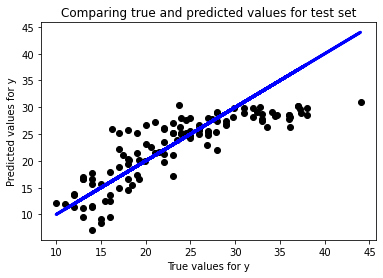

In [58]:
# Comparing true versus predicted values
plt.scatter(y_test, pred_nn, color='black')
plt.plot(y_test, y_test, color='blue', linewidth=3)
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

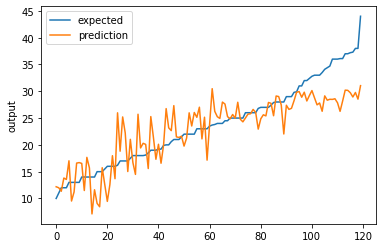

In [31]:
#Regression lift Chart
chart_regression(pred_nn.flatten(),y_test)